Submitted by Group 91 

Sushil Kulkarni (470452709), 
Disha Mendapara(490494736)
Anjali Upadhyay (490451474)

In [25]:
# Mount google drive on Colab. Only use if running on Google Colab
# You will need gmail id for this. Please grant access when prompted

from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Import libraries 

#import pandas as pd
import h5py
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import chain
from datetime import datetime, timedelta
import warnings
from scipy.stats import multivariate_normal 
from collections import defaultdict

### The path of the input files. Please change this to your local path

path='/content/gdrive/My Drive/ML-5318/'
###

label_dict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

train=0.9  ## Traning Data
test=0.1  ## Validation Data





In [0]:
# Open h5 file and convert to numpy

with h5py.File(path+'Dataset_Assignment1/images_training.h5','r') as H:
  data = np.copy(H['data'])
with h5py.File(path+'Dataset_Assignment1/labels_training.h5','r') as H:
  lbl = np.copy(H['label'])
with h5py.File(path+'Dataset_Assignment1/labels_testing_2000.h5','r') as H:
  test_label = np.copy(H['label'])
with h5py.File(path+'Dataset_Assignment1/images_testing.h5','r') as H:
  test_data = np.copy(H['data'])

In [0]:
# Reshape array from 3D to 2D & split train test

nsamples, nx, ny = data.shape
testsamples, nx, ny = test_data.shape

## Training Set

data_tr=data[0:int(nsamples*train)]
data_tr = data_tr.reshape((int(nsamples*train),nx*ny))
lbl_tr=lbl[0:int(nsamples*train)]


## Validation Set
data_val=data[int(nsamples-nsamples*test):]
data_val = data_val.reshape(int(nsamples*test),nx*ny)
lbl_val=lbl[int(nsamples-nsamples*test):]



## Test set.
data_tst=test_data[0:2000]   # take only first 2k rows
data_tst = data_tst.reshape(2000,nx*ny)
lbl_tst=test_label




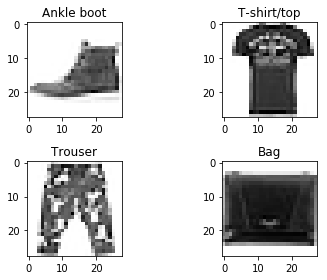

In [10]:
# Show Samples
# Get 28x28 image

plt.subplot(2, 2, 1)
sample_1 = data[1100].reshape(28,28)
sample_label_1 = lbl[1100] 
plt.title(label_dict[sample_label_1])
plt.imshow(sample_1, cmap='Greys')


plt.subplot(2, 2, 2)
sample_2 = data[0].reshape(28,28)
sample_label_2 = lbl[0] 
plt.title(label_dict[sample_label_2])
plt.imshow(sample_2, cmap='Greys')

plt.subplot(2, 2, 3)
sample_3 = data[3100].reshape(28,28)
sample_label_3 = lbl[3100] 
plt.title(label_dict[sample_label_3])
plt.imshow(sample_3, cmap='Greys')


plt.subplot(2, 2, 4)
sample_4 = data[145].reshape(28,28)
sample_label_4 = lbl[145] 
plt.title(label_dict[sample_label_4])
plt.imshow(sample_4, cmap='Greys')

plt.tight_layout()
plt.show()


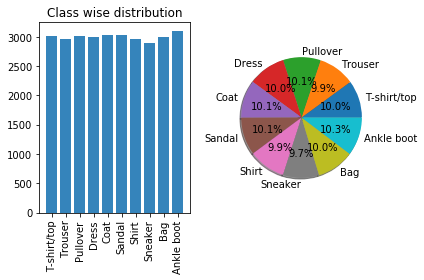

In [11]:
# Plot class wise distribution of labels


warnings.filterwarnings('ignore')

plt.subplot(1, 2, 1)

#sns.distplot(lbl,kde = False )

objects = label_dict.values()
y_pos = np.arange(len(objects))

plt.bar(y_pos, np.bincount(lbl), align='center', alpha=0.9)
plt.xticks(y_pos, objects, rotation=90)
plt.title('Class wise distribution')


plt.subplot(1, 2, 2)

plt.pie(np.bincount(lbl), labels=label_dict.values(), autopct='%1.1f%%', shadow=True)

 
plt.tight_layout()
plt.show()

In [0]:
#### Preprocessing the data 

def pca_Custom(data, no_of_dim):

    ## Normalizing the data by subtracting the mean and dividing by std
    data=(data-np.mean(data))/np.std(data)
    cov_mat=np.cov(data.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs.sort()
    eig_pairs.reverse()

    ## Rearrange the matrix into the new subspace 
    w=[]
    for i in range(no_of_dim):
      w.append((eig_pairs[i][1].reshape(784,1)))
    matrix_w=np.array(w).reshape(784,no_of_dim)
    

  
    return matrix_w
  

 ## Finding the refined PCA data for training and validation 

matrix_w=pca_Custom(data_tr,400)
data_tr_PCA=data_tr.dot(matrix_w)
data_val_PCA=data_val.dot(matrix_w)
data_tst_PCA=data_tst.dot(matrix_w)

In [0]:

# Perform SVD on the numpy matrix
k=400

U, s, V = np.linalg.svd(data_tr, full_matrices=False)
data_tr_SVD = np.dot(U[:,:k],np.diag(s[:k])) 

U, s, V = np.linalg.svd(data_val, full_matrices=False)
data_val_SVD = np.dot(U[:,:k],np.diag(s[:k])) 

In [0]:
# Logistic Regression classifier code

class LogisticRegressionOVR(object):
    def __init__(self, eta=0.9, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
        
    ## This function will calcualte the appropriate weights after iterating over multiple times 
    ## This works on one class vs all.and return the results along with the class.
    def fit(self, X, y):
        X = np.insert(X, 0, 1, axis=1)
        self.w = []
        m = X.shape[0]

        for i in np.unique(y):
            y_copy = np.where(y == i, 1, 0)
            w = np.ones(X.shape[1])

            for _ in range(self.n_iter):
                output = X.dot(w)
                errors = y_copy - self._sigmoid(output)
                w += self.eta / m * errors.dot(X)
            self.w.append((w, i))
        return self
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict(self, X):
        return [self._predict_one(i) for i in np.insert(X, 0, 1, axis=1)]

    ## We will predict the output after multiplying our input set with the best weights selected by the algorithm.
    def _predict_one(self, x):
        return max((x.dot(w), c) for w, c in self.w)[1]   
    
    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)

    

In [0]:
# Naive Bayes

class NaiveBayesClassfier(object):
   
      ## Calculate the mean and variance of the seperated data  
      def fit(self,data,label):
          data=self.seperationbyclasses(data,label,noofClasses=len(np.unique(label)))
          self.mean=[]
          self.variance=[]
          for data_values in data:
            self.mean.append(np.mean(data_values,axis=0))
          for data_values in data:
            self.variance.append(np.var(data_values,axis=0))
           
          self.prob_density=np.bincount(label)/len(label)
          return self
        
      ## We seperate the data via different classes   
      def seperationbyclasses(self,data,label,noofClasses):
          seperated = []
          seperated = [[] for i in range(noofClasses)]
          for data, label in zip(data, label):
            seperated[label].append(data)
          return [np.array(data) for data in seperated]
      
      
      ## We will use this mean and the variace of the dataset collected to get the probability density function for the new data.
      def predict(self,data):
           predictions=[]
           for mean,variance,prob_density in zip(self.mean,self.variance,self.prob_density):
              predictions.append(np.log(prob_density)+ multivariate_normal.logpdf(data, mean, variance, True))
           return np.argmax(np.array(predictions), axis=0)
        

      def score(self, data,label):
        return sum(self.predict(data) == label) / len(label)

In [0]:
## KNN classifier

class KNearestNeighborsClassifier(object):

  #saving n_neighbors as an instance
  # taking distance into account, give closer points more weight
  #setting default values of neighbors weight and distpara
    def __init__(self, n_neighbors=5, weights='uniform', distpara=2):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.distpara = distpara

        
  #saves Instances to Two Variables X and Y

    def fit(self, X, y):
        self.X = X
        self.y = y
        return self

    def calculating_distance(self, data1, data2):
    #  considering p as 1 or 2 
    # 1-> Manhattan Distance and 2-> Euclidean distance
        if self.distpara == 1:  
    # returns Maanhattan Distance (to calculate distance between two points)
            return sum(abs(data1 - data2))          
        elif self.distpara == 2:    
    # returns Euclidean Distance
            return np.sqrt(sum((data1 - data2)**2))
            raise ValueError("p not recognized: should be 1 or 2")

    def computing_weights(self, distances):
    # compute uniform weights
        if self.weights == 'uniform':
            return [(1, y) for d, y in distances]
        elif self.weights == 'distance':
     # collects all the samples whose distance is zero and assigns a value 1 
            matches = [(1, y) for d, y in distances if d == 0]
            return matches if matches else [(1/d, y) for d, y in distances]
    # when distance is zero you will gett error on every single instance and hence get a division by 0 error
        raise ValueError("weights not recognized: should be 'uniform' or 'distance'")

        
    #  predicts only one instance 
    def predicting_one_instance(self, test):
    # sort the samples function sorts by the first element by pair of distance and a target class
        distances = sorted((self.calculating_distance(x, test), y) for x, y in zip(self.X, self.y)) 
    #  calls _compute_weights function
        weights = self._computing_weights(distances[:self.n_neighbors])
    # grouping weights by classes using defaultdict
        weights_by_class = defaultdict(list)
        for d, c in weights:
            weights_by_class[c].append(d)
    #  sum is used to count how many members belong to eachc class then takes the majority with max(looks at first element by default and second element as a predicted class)   
        return max((sum(val), key) for key, val in weights_by_class.items())[1]

      
    #  predicts multiple instances by calling _predict_one several times and saves them to the list
    def predicting_multiple_instances(self, X):
        return [self.predicting_one_instance(x) for x in X]

      
      
      # calculating  mean accuracy of the given test data
    def score(self, X, y):
        return sum(1 for p, t in zip(self.predict(X), y) if p == t) / len(y)

In [0]:
# Label encoder
    
class LabelEncoder_Custom():
      """Encode labels with value between 0 and n_classes-1.
      """

      def fit(self, y):
          """Fit label encoder
          """
          y = np.ravel(y)
          self.classes_ = np.unique(y)
          return self

      def transform(self, y):
          """Transform labels to normalized encoding.
          """
          y = np.ravel(y)

          if y.shape[0] == 0:
               return np.array([])

          classes = np.unique(y)

          return np.searchsorted(self.classes_, y)


      def _unique_multiclass_Custom(self,y):
          return np.unique(np.asarray(y))


      def unique_labels_Custom(self,*ys):
          _unique_labels = self._unique_multiclass_Custom
          ys_labels = set(chain.from_iterable(_unique_labels(y) for y in ys))
          return np.array(sorted(ys_labels))
      


In [0]:
# Print custom classification report

def classification_report_Custom(y_true, y_pred, target_names):

      le = LabelEncoder_Custom()     
      labels_given = True
      labels = le.unique_labels_Custom(y_true, y_pred)
      digits = 2

      last_line_heading = 'avg / total'

      name_width = max(len(cn) for cn in target_names)

      width = max(name_width, len(last_line_heading), 2)

      headers = ["precision", "recall", "f1-score"]    

      head_fmt = u'{:>{width}s} ' + u' {:>9}' * len(headers)
      report = head_fmt.format(u'', *headers, width=width)
      report += u'\n'


      p, r, f1 = precision_recall_fscore_support_Custom(y_true, y_pred, 
                                                         labels=labels)

      row_fmt = u'{:>{width}s} ' + u' {:>9.{digits}f}' * 3 + '\n'


      rows = zip(target_names, p, r, f1)


      for row in rows:
          report += row_fmt.format(*row, width=width, digits=digits)


      report += u'\n'

      report += row_fmt.format(last_line_heading,
                       np.average(p),
                       np.average(r),
                       np.average(f1),
                       width=width, digits=digits)

      results = []
      results.insert(0, report)
      results.insert(1, np.average(p))
      results.insert(2, np.average(r))
      results.insert(3, np.average(f1))

      return report

In [0]:
# precision recall fscore function

def precision_recall_fscore_support_Custom(y_true, y_pred, labels=None):
    
   
     beta = 1.0
     sample_weight = None
     le = LabelEncoder_Custom()

     y_true = np.ravel(y_true)
     y_pred = np.ravel(y_pred)

     present_labels = le.unique_labels_Custom(y_true, y_pred)

     n_labels = len(labels)
     labels = np.hstack([labels, np.setdiff1d(present_labels, labels, 
                                               assume_unique=True)])

     # Calculate tp_sum, pred_sum, true_sum ###

     le.fit(labels)
     y_true = le.transform(y_true)
     y_pred = le.transform(y_pred)
     sorted_labels = le.classes_

     # labels are now from 0 to len(labels) - 1 -> use bincount
     tp = y_true == y_pred
     tp_bins = y_true[tp]

     tp_bins_weights = None

     tp_sum = np.bincount(tp_bins, weights=tp_bins_weights, minlength=len(labels))

     pred_sum = np.bincount(y_pred, weights=sample_weight, minlength=len(labels))

     true_sum = np.bincount(y_true, weights=sample_weight, minlength=len(labels))

     # Retain only selected labels
     indices = np.searchsorted(sorted_labels, labels[:n_labels])
     tp_sum = tp_sum[indices]
     true_sum = true_sum[indices]
     pred_sum = pred_sum[indices]

     # Finally, we have all our sufficient statistics. Divide! #

     precision = tp_sum / pred_sum
     precision=np.where(np.isnan(precision), 0, precision)
      
     recall =  tp_sum / true_sum
     recall=np.where(np.isnan(recall), 0, recall)


     beta2 = beta ** 2

     f_score = ((1 + beta2) * precision * recall /
            (beta2 * precision + recall))

     f_score[tp_sum == 0] = 0.0
     f_score=np.where(np.isnan(f_score), 0, f_score)
    
     return precision, recall, f_score

In [0]:
# Compare inter class precision

def inter_class_precision_Custom(data_tst, lbl_tst, classifier):
  


    keys=np.fromiter(label_dict.keys(), dtype=int)

    
    if classifier == 'logi':
       precision, recall, f_score=precision_recall_fscore_support_Custom(lbl_tst, logi.predict(data_tst), keys)
    elif classifier == 'nb':
       precision, recall, f_score=precision_recall_fscore_support_Custom(lbl_tst, nb.predict(data_tst), keys)
    elif classifier == 'knn':
       precision, recall, f_score=precision_recall_fscore_support_Custom(lbl_tst, knn.predict(data_tst), keys)
    
    

    y_pos = np.arange(len(label_dict.values()))

    plt.bar(y_pos, np.around(precision*100, decimals=0), align='center', alpha=0.9)

    plt.xticks(y_pos, label_dict.values(),rotation=90)
    plt.ylabel('Precision')
    plt.title('Class wise Precision')
    plt.show()



0.7536296296296296
Training Time 15.933679secs 
Val Accuracy: 0.7466666666666667
Test Accuracy: 0.7505
             precision    recall  f1-score
T-shirt/top       0.78      0.69      0.73
    Trouser       0.99      0.95      0.97
   Pullover       0.54      0.76      0.63
      Dress       0.74      0.84      0.79
       Coat       0.50      0.84      0.62
     Sandal       0.87      0.80      0.83
      Shirt       0.00      0.00      0.00
    Sneaker       0.87      0.88      0.88
        Bag       0.93      0.83      0.88
 Ankle boot       0.87      0.91      0.89

avg / total       0.71      0.75      0.72



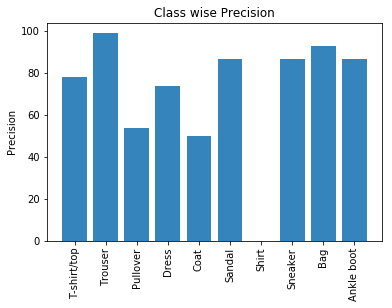

In [23]:
# Fit data and predict

t0 = time()

logi = LogisticRegressionOVR(n_iter=100).fit(data_tr_PCA, lbl_tr)

print(logi.score(data_tr_PCA, lbl_tr))
print("Training Time %fsecs " % (time() - t0))
print('Val Accuracy:',logi.score(data_val_PCA, lbl_val))
print('Test Accuracy:',logi.score(data_tst_PCA,lbl_tst))
print(classification_report_Custom(lbl_tst, logi.predict(data_tst_PCA),label_dict.values())) 
inter_class_precision_Custom(data_tst_PCA, lbl_tst, 'logi')




Training Time 0.135796secs 
Val Accuracy: 0.704
Test Accuracy: 0.705
             precision    recall  f1-score
T-shirt/top       0.71      0.70      0.70
    Trouser       0.99      0.90      0.94
   Pullover       0.64      0.50      0.56
      Dress       0.69      0.83      0.75
       Coat       0.58      0.63      0.60
     Sandal       0.56      0.73      0.63
      Shirt       0.36      0.24      0.29
    Sneaker       0.78      0.84      0.81
        Bag       0.91      0.80      0.85
 Ankle boot       0.83      0.90      0.86

avg / total       0.70      0.71      0.70



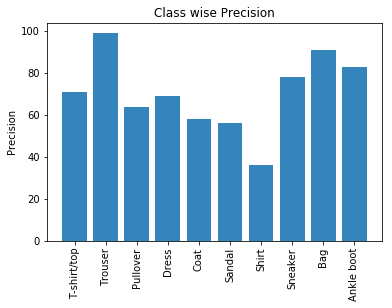

In [24]:
t0 = time()

nb=NaiveBayesClassfier().fit(data_tr_PCA, lbl_tr)
print("Training Time %fsecs " % (time() - t0))
print('Val Accuracy:',nb.score(data_val_PCA, lbl_val))
print('Test Accuracy:',nb.score(data_tst_PCA,lbl_tst))
print(classification_report_Custom(lbl_tst, nb.predict(data_tst_PCA),label_dict.values())) 
inter_class_precision_Custom(data_tst_PCA, lbl_tst, 'nb')




Val Accuracy: 0.764
Training Time 790.850553secs 
Test Accuracy: 0.735
Training Time 1322.022800secs 
             precision    recall  f1-score
T-shirt/top       0.63      0.80      0.71
    Trouser       0.99      0.93      0.96
   Pullover       0.61      0.67      0.63
      Dress       0.83      0.79      0.81
       Coat       0.59      0.62      0.60
     Sandal       0.87      0.63      0.73
      Shirt       0.46      0.38      0.41
    Sneaker       0.73      0.87      0.79
        Bag       0.93      0.81      0.87
 Ankle boot       0.79      0.90      0.84

avg / total       0.74      0.74      0.74



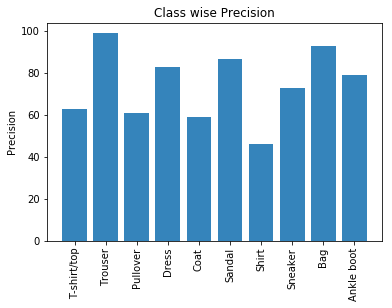

In [0]:
## Calculating the 40 PCA components to perform KNN.
matrix_w=pca_Custom(data_tr,40)
data_tr_PCA=data_tr.dot(matrix_w)
data_val_PCA=data_val.dot(matrix_w)
data_tst_PCA=data_tst.dot(matrix_w)



t0 = time()
knn = KNeighborsClassifier().fit(data_tr_PCA, lbl_tr)
print('Val Accuracy:',knn.score(data_val_PCA, lbl_val))
print("Training Time %fsecs " % (time() - t0))

print('Test Accuracy:',knn.score(data_tst_PCA,lbl_tst))
print("Training Time %fsecs " % (time() - t0))
print(classification_report_Custom(lbl_tst, knn.predict(data_tst_PCA),label_dict.values())) 
inter_class_precision_Custom(data_tst_PCA, lbl_tst, 'knn')
